In [1]:
import numpy as np
from numpy.testing._private.nosetester import _numpy_tester
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
#import sys
import torch 
#import importlib
import math
import seaborn as sns
import torch.nn as nn


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

filename = 'Regression_Data.txt'
path = "/home/apaulraj/CONUS_GroundWater_Mapping"

#  Variable selection:  
# Choices:
# ['WTD', 'elev', 'PME', 'lnK', 'slope', 'TopoIndex', 'Nrelief', 'Neloc', 'Nefrac', 'Norder', 'Nslope', 'NlnK',
#    'Nvark', 'NPME', 'Rrelief', 'Reloc', 'Refrac', 'Rslope', 'Rlnk', 'Rvark', 'RPME', 'Rarea', 'Rareafrac']
target_name = 'WTD'    # variable to be used as the label
covar_names = ['PME', 'lnK', 'TopoIndex', 'slope'] #variables to use as channels

# Nvark has NaN so excluded for now

output_name = 'mseloss'  # Name to give to the trained model

import Shapes
from Shapes import PFslice2D
import utilities as utilities

cuda:0


(1888, 3342, 23)
(1888, 3342, 23)


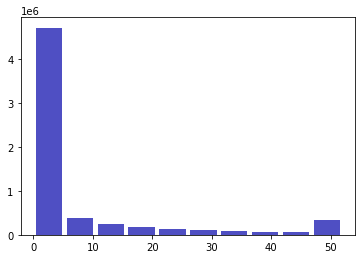

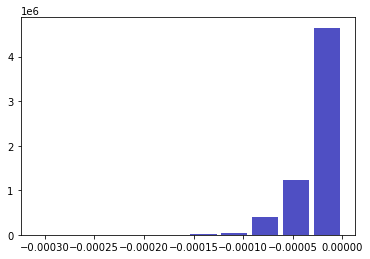

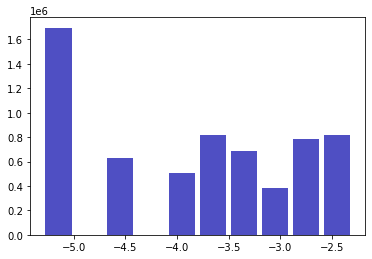

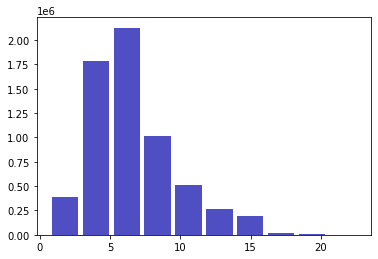

Var, Raw Min, Raw Max, Scaled Min, Scaled Max
WTD 0.0 52.0 0.0 1.0
YOOOOO
elev -82.5 4225.0 0.0 1.0
PME -0.0003113056 0.0 0.0 1.0
lnK -5.29831736654804 -2.30258509299405 0.0 1.0
slope 1e-05 0.5 0.0 1.0
TopoIndex 0.693147180559945 22.6673972621528 0.0 1.0
Nrelief 0.0 3078.5 0.0 1.0
Neloc 0.0 100.647249190939 0.0 1.0
truncating mins
Nefrac 0.0 100.0 0.0 1.0
truncating mins
Norder 0.0 353.0 0.0 1.0
Nslope 0.0 0.298597833333333 0.0 1.0
NlnK -5.29831736654804 0.0 0.0 1.0
Nvark 0.0 2.69232355644389 0.0 1.0
NPME 0.0 2.3324911448495 0.0 1.0
Rrelief 0.0 4291.5 0.0 1.0
Reloc 0.0 743.415077202543 0.0 1.0
truncating mins
Refrac 0.0 743.415077202543 0.0 1.0
truncating mins
Rslope 0.0 0.269042892307692 0.0 1.0
Rlnk -5.29831736654804 0.0 0.0 1.0
Rvark 0.0 1.88094643594086 0.0 1.0
RPME 0.0 2.33249114484951 0.0 1.0
Rarea 0.0 2180870.0 0.0 1.0
Rareafrac 0.0 803.13096123677 0.0 1.0
truncating mins
AFTER SCALING


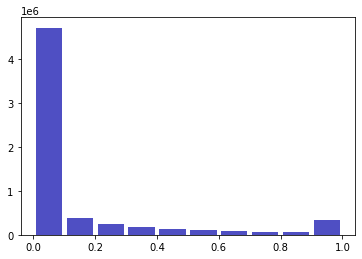

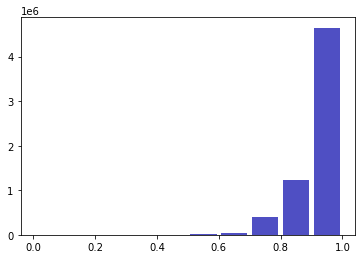

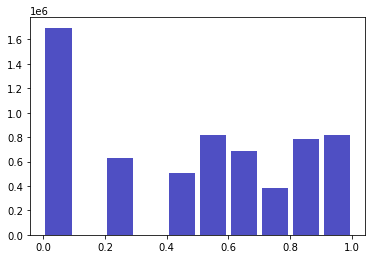

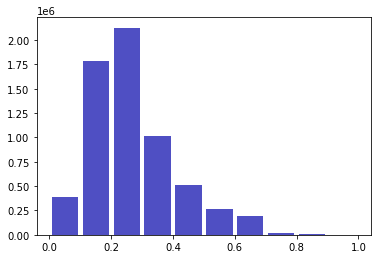

In [2]:
ny = 1888
nx = 3342
ncell = nx*ny
index_list = np.array(list(range(ncell)))
from scipy.stats import zscore
# Read in raw data as pandas data frame
filepath = os.path.join(path, filename)
raw_data = pd.read_table(filepath, sep=',', header=0, index_col=None)
#raw_data = raw_data.apply(zscore)
#print(raw_data['WTD'])

#raw_data['WTD'] = np.sqrt((raw_data['WTD']))
#raw_data['PME'] = np.sqrt((-1*raw_data['PME']))
#print(raw_data[raw_data.isna().any(axis=0)])

#Convert the data into a 3D numpy array with 2D matrices for each column
data_array = np.zeros((ny,nx,raw_data.shape[1]))
ztemp=0
for i in list(raw_data):
    #print(i)
    #raw_data.loc[raw_data[i] == -9999, i] = np.nan #replace -9999's with NAs
    temp=raw_data[i].values
    data_array[:, :, ztemp] = np.flipud(temp.reshape(ny, nx, order='C'))
    ztemp += 1

from scipy import stats
print(data_array.shape)
x_min = 0
x_max = nx #1232
y_min = 0 #1150
y_max = ny
data_array = data_array[y_min:y_max,x_min:x_max,:]
print(data_array.shape)

def normalize_2d(matrix):
    return stats.zscore(matrix, axis=None)


WTD = data_array[:,:,0]
wtdmean = np.mean(WTD)
wtdstd = np.std(WTD)
PME = data_array[:,:,2]
lnK = data_array[:,:,3]
TopoIndex = data_array[:,:,5]

# for i in range(23):
#     data_array[:,:,i] = normalize_2d(data_array[:,:,i])

from matplotlib import pyplot as plt
plt.hist(WTD.ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

plt.hist(PME.ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

plt.hist(lnK.ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

plt.hist(TopoIndex.ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

var_names = list(raw_data)
nvar=len(var_names)
var_summary = pd.DataFrame(data=None, index=var_names)

var_summary['max_raw'] = raw_data.max()
var_summary['min_raw'] = raw_data.min()

var_summary['max_val'] = var_summary['max_raw']
var_summary['min_val'] = var_summary['min_raw']
var_summary.loc[['Reloc', 'Refrac', 'Neloc',
                 'Nefrac', 'Rareafrac'], 'min_val'] = 0.0

var_summary['min_scaled'] = np.zeros(nvar)
var_summary['max_scaled'] = np.ones(nvar)

# NOTE - might want a flag for log options on the scaling

#Scale data
data_scaled = data_array.copy()
data_unscaled = data_array.copy()
ztemp = 0
print("Var, Raw Min, Raw Max, Scaled Min, Scaled Max")
counter = 0
for i in list(raw_data):
    min_r = var_summary.loc[i, 'min_raw']
    max_r = var_summary.loc[i, 'max_raw']
    min_i = var_summary.loc[i, 'min_val']
    max_i = var_summary.loc[i, 'max_val']
    min_f = var_summary.loc[i, 'min_scaled']
    max_f = var_summary.loc[i, 'max_scaled']
    print(i, min_i, max_i, min_f, max_f)

    #adjust any values outside the desired range
    temp=data_array[:,:, ztemp]
    if min_r < min_i:
        print('truncating mins')
        temp[temp<min_i] = min_i

    if max_r > max_i:
        print('truncating maxs')
        temp[temp > max_i] = max_i
    
    if (counter==0):
        counter = counter + 1
        print("YOOOOO")
        wtdmin = min_i
        wtdmax = max_i

    #rescale
    data_scaled[:, :, ztemp] = (temp - min_i)/(max_i-min_i) * (max_f-min_f) + min_f
    #print(i, ztemp, np.min(data_scaled[:, :, ztemp]),
    #      np.max(data_scaled[:, :, ztemp]))
    ztemp += 1
    
print("AFTER SCALING")

plt.hist(data_scaled[:,:,0].ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

plt.hist(data_scaled[:,:,2].ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

plt.hist(data_scaled[:,:,3].ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

plt.hist(data_scaled[:,:,5].ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

In [3]:
xs = []
ys = []
patch_width = 50

x_unique = [[] for i in range(x_max-x_min-(patch_width-1))]
#print(x_unique)

run_size = 10000      # total number of clips to take
#nx=2242
for i in range(run_size):
    currentx = np.random.randint(patch_width, x_max-x_min-(patch_width-1))
    xs.append(currentx)  # 0 to nx-(patch_width-1)
    currenty = np.random.randint(0, y_max-y_min-(patch_width-1))
    #print(currentx)
    #print(x_unique[currentx])
    while(currenty in x_unique[currentx]):
        #print("yo")
        currenty = np.random.randint(0, y_max-y_min-(patch_width-1))
    
    ys.append(currenty)
    x_unique[currentx].append(currenty)
    
print(len(xs))
print(len(ys))

# index_max = (x_max-x_min-(patch_width-1))*(y_max-y_min-(patch_width-1))

# # generate indices for lower left corners for clips
# ind_list = set()
# ind_size = 0

# while ind_size < run_size:
#     r = random.randint(0, index_max)
#     if r not in ind_list:
#         ind_size += 1
#         ind_list.add(r)


    
val_start = int(run_size*0.6)
test_start = int(run_size*0.8)
train_x = xs[:val_start]
train_y = ys[:val_start]

# toggle for "ood"/true testing
# val_x = [0 for i in range(y_max-y_min-(patch_width-1))]
# test_x = [0 for i in range(y_max-y_min-(patch_width-1))]
# val_y = [i for i in range(y_max-y_min-(patch_width-1))]
# test_y = [i for i in range(y_max-y_min-(patch_width-1))]

# print(val_x)
# print(test_x)
# print(val_y)
# print(test_y)

val_x = xs[val_start:test_start]
val_y = ys[val_start:test_start]
test_x = xs[test_start:]
test_y = ys[test_start:]


10000
10000


In [51]:
target_index = var_names.index(target_name)
covar_index=[var_names.index(x) for x in covar_names]


# Figure out data sizes
nchannel = len(covar_names)
D_in = nchannel * patch_width^2
D_out = patch_width ** 2

#from UNet_Experiment import RMM_NN as ConvNet
#from NN_2D import ConvNet
from AndrewCNN import BasicConvNet as ConvNet

print('-----------------------------')
print("  NN Model information")
print()

model = ConvNet(input_channels = 4,
        hidden_channels = 64,
        output_channels = 1,
        kernel_size = 7,
        depth = 3,
        activation = nn.functional.selu)
model.to(DEVICE)

model.verbose = False
model.use_dropout = False

print("-- Model Definition --")
print(model)

print("-- Model Parameters --")
utilities.count_parameters(model)


-----------------------------
  NN Model information

-- Model Definition --
BasicConvNet(
  (layers): ModuleList(
    (0): ConvBlock(
      (conv): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    )
    (2): ConvBlock(
      (activation): Identity()
      (conv): Conv2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    )
  )
)
-- Model Parameters --
+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
| layers.0.conv.weight |   12544    |
|  layers.0.conv.bias  |     64     |
| layers.1.conv.weight |   200704   |
|  layers.1.conv.bias  |     64     |
| layers.2.conv.weight |    3136    |
|  layers.2.conv.bias  |     1      |
+----------------------+------------+
Total Trainable Params: 216513


216513

In [52]:
from WTDDataset import MyDataset
from WTDDatasetTranspose import MyDataset as transposed
from WTDDataset_Augmented import MyDataset as augmented
from torch.utils.data import DataLoader

train_dataset = MyDataset(data_scaled, train_x, train_y, patch_width, covar_index, target_index)
val_dataset = MyDataset(data_scaled, val_x, val_y, patch_width, covar_index, target_index)
test_dataset = MyDataset(data_scaled, test_x, test_y, patch_width, covar_index, target_index)

train_batchsize = 200
train_loader = DataLoader(train_dataset, train_batchsize)
val_loader = DataLoader(val_dataset, batch_size = 20)
test_loader = DataLoader(test_dataset, batch_size = 20)



In [53]:
import torch.nn.functional as F
class Trainer():
    def __init__(self,net=None,optim=None,sched=None, train_loader=None, val_loader=None):
        self.net = net
        self.optim = optim
        self.sched = sched
        #self.l1 = l1
        #self.l2 = l2
        #self.loss_function = loss_function
        self.train_loader = train_loader
        self.val_loader = val_loader
        # self.sched = sched
        #net = net.float()
    def train(self,epochs):
        losses = []
        val = []
        #self.net = self.net.float()
        #params = self.net.parameters()
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_steps = 0
            val_loss = 0.0
            val_steps = 0
            # print("yo")
            for data in self.train_loader:
                #print("sup")
                # print(type(data[0]))
                data_in = data[0].float()
                y = data[1].float()
#                 print(type(data_in))
#                 print(type(y))
                #y = y.type(torch.LongTensor)
#                 torch_input = torch.from_numpy(data_in)
#                 torch_label = torch.from_numpy(y)
                torch_input = data_in.type(torch.FloatTensor).to(DEVICE)
                torch_label = y.type(torch.FloatTensor).to(DEVICE)
                #print(torch_input)
#                 print(y.shape)
#                 print(y)
                self.optim.zero_grad()
                output = np.squeeze(self.net(torch_input))
                output = output.reshape((train_batchsize, patch_width**2)) # added this for andrew outputting an image instead of a line
                #print(output)
#                 print(output.shape)
                #loss = self.loss_function(output, torch_label)
                loss = F.mse_loss(output, torch_label)
#                 l2_loss = self.l2(output,torch_label)
#                 loss = l1_loss + l2_loss
                #loss.register_hook(lambda grad: print(grad))
                loss.backward()
                totalnorm = 0
#                 for p in list(filter(lambda p: p.grad is not None, self.net.parameters())):
#                     totalnorm += p.grad.data.norm(2).item()**2
#                 print(np.sqrt(totalnorm))
#                 if(epoch >= 0):
#                     torch.nn.utils.clip_grad_norm_(self.net.parameters(), 1)

# #CLIPPING
#                 if(epoch >= 0):
#                     for p in params:
#                         p.register_hook(lambda grad: torch.clamp(grad, -20, 20))

                self.optim.step()
                epoch_loss += loss.item()
                epoch_steps += 1
            
            for vdata in self.val_loader:
                vdata_in = vdata[0].float()
                vy = vdata[1].float()
                vtorch_input = vdata_in.type(torch.FloatTensor).to(DEVICE)
                vtorch_label = vy.type(torch.FloatTensor).to(DEVICE)
                voutput = np.squeeze(self.net(vtorch_input))
                voutput = voutput.reshape((20, patch_width**2)) # added this for andrew outputting an image instead of a line
                vloss = F.mse_loss(voutput, vtorch_label)
#                 v2loss = self.l2(voutput, vtorch_label)
#                 vloss = v1loss + v2loss
                val_loss += vloss.item()
                val_steps += 1
            
            losses.append(epoch_loss / epoch_steps)
            val.append(val_loss / val_steps)
#             print("epoch [%d]: train loss %.6f" % (epoch+1, losses[-1]), end=' '),
#             print("epoch [%d]: val loss %.6f" % (epoch+1, val[-1]), end=' '),
            print(epoch+1, losses[-1], val[-1])
            print("Epoch: %3d, training loss: %5.3e, validation loss: %5.3e" % (epoch+1, losses[-1], val[-1]), end='\r')
            
            
            self.sched.step(val[-1])

            
        return losses, val

In [54]:
import torch.optim as optim
import torch.nn as nn
import time

learning_rate = 5e-3
#opt = optim.AdamW(model.parameters(), lr=learning_rate)
#opt = optim.Adamax(model.parameters(), lr=learning_rate)
opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt)
#loss_function = nn.SmoothL1Loss()
# l1 = myLoss()
# l2 = nn.MSELoss()
trainer = Trainer(net=model, optim=opt, sched=scheduler, train_loader=train_loader, val_loader=val_loader)
#net = net.float()
start = time.time()
losses, val = trainer.train(epochs=50)
end = time.time()
print(end-start)


1 0.13057268125315508 0.050841257199645044
2 0.04909718632698059 0.046407122444361446dation loss: 5.084e-02
3 0.04519706033170223 0.042962485793977975dation loss: 4.641e-02
4 0.042853010321656865 0.04024017754942179dation loss: 4.296e-02
5 0.041001516456405325 0.038514175824820994ation loss: 4.024e-02
6 0.043257963533202805 0.03902456484735012dation loss: 3.851e-02
7 0.03812795424213012 0.0357544419914484lidation loss: 3.902e-02
8 0.040418247878551486 0.039188754260540005ation loss: 3.575e-02
9 0.03590102990468343 0.03450372252613306idation loss: 3.919e-02
10 0.03454079621781905 0.032927578818053006ation loss: 3.450e-02
11 0.036781694553792474 0.03341779202222824ation loss: 3.293e-02
12 0.033298198816676935 0.03142909409478307ation loss: 3.342e-02
13 0.031986950896680355 0.03173935214057565ation loss: 3.143e-02
14 0.03127973669519027 0.030375364013016225ation loss: 3.174e-02
15 0.031864356125394504 0.029714913265779616tion loss: 3.038e-02
16 0.03037126107762257 0.02924746034666896datio

Text(0, 0.5, 'mse Loss')

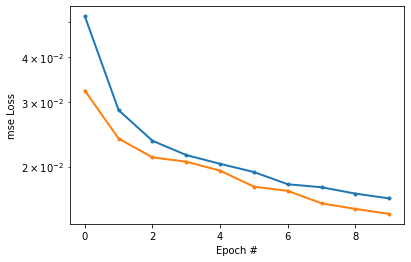

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses[::], linewidth=2, linestyle='-', marker='.')
plt.plot(val[::], linewidth=2, linestyle='-', marker='.')
plt.semilogy()
#plt.legend()
plt.xlabel('Epoch #')
plt.ylabel('mse Loss')

wtd max:  52.0
[[0.00000000e+00 6.09699972e-02 4.35148001e+00 ... 4.51260000e-01
  1.17400000e-02 2.55199987e-02]
 [6.92899972e-02 0.00000000e+00 0.00000000e+00 ... 2.61970013e-01
  0.00000000e+00 0.00000000e+00]
 [4.71069412e+01 3.64646111e+01 3.33557014e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.95399998e-02 1.33866000e+00 1.82000000e-03 ... 0.00000000e+00
  1.15600005e-01 6.95418978e+00]
 [5.20000000e+01 5.20000000e+01 4.04464607e+01 ... 7.60445023e+00
  1.14363899e+01 1.99817486e+01]
 [3.50500010e-02 3.68300006e-02 6.52399957e-02 ... 8.19199979e-02
  6.00400008e-02 2.31599994e-02]]
my output
[[ 6.940246    7.979392    8.630316   ...  2.5894825   3.4084163
   3.4091153 ]
 [ 0.          0.          0.         ...  2.6177344   3.3176582
   2.5608194 ]
 [16.27906    18.816235   22.64081    ... 10.802507   11.23403
  11.883089  ]
 ...
 [ 5.6217504   7.2432227   7.810859   ...  0.92501855  2.91509
   2.6957228 ]
 [18.394009   21.923653   27.486656   ...  4.4032884  

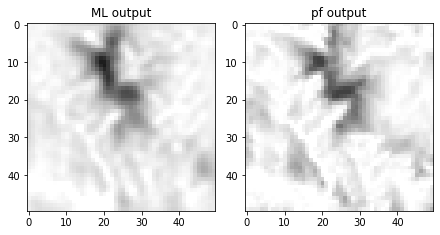

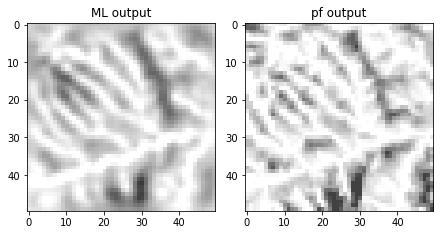

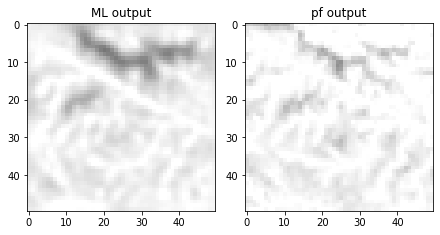

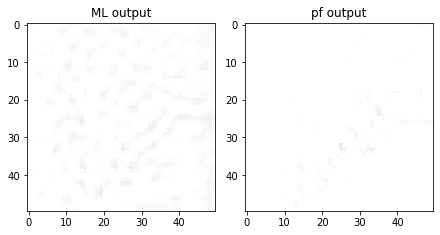

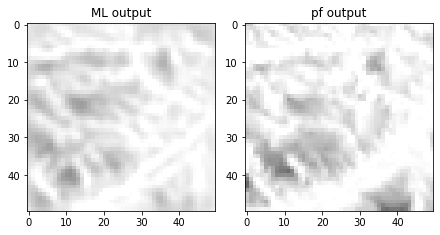

70.11469
0.0
52.0
0.0
losses
3.9803274
4.338979
7.6165576
median
4.3395605
stddevs
0.7405811
0.7572892
0.98680466


In [13]:
print("wtd max: ", wtdmax)
wtdmax = 52
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
from scipy.signal import convolve2d

t_loss = []
t2_loss = []
t3_loss = []
counter = 0
for data in val_loader:
    data_in = data[0].float()
    y = data[1].float()
    torch_input = data_in.type(torch.FloatTensor).to(DEVICE)
    torch_label = y.type(torch.FloatTensor).to(DEVICE)
    output = np.squeeze(model(torch_input))
    output = output.reshape((20, patch_width**2))
    torch_label = (torch.mul(torch_label, wtdmax))
    output = (torch.mul(F.relu(output), wtdmax))
    #output[output > 52] = 52
    loss = F.smooth_l1_loss(output, torch_label)
    loss2 = F.l1_loss(output, torch_label)
    loss3 = torch.sqrt(F.mse_loss(output, torch_label))
    t_loss.append(loss.data.cpu().numpy())
    t2_loss.append(loss2.data.cpu().numpy())
    t3_loss.append(loss3.data.cpu().numpy())

    counter = counter + 1
#     if (counter>100):
#         break
    
    if (counter == 1):
        print(torch_label.data.cpu().numpy())
        print("my output")
        print(output.data.cpu().numpy())
    
    #contrast_output = torchvision.transforms.functional.adjust_contrast(output.data.cpu(), 1.5)
    
    if (counter%20 == 0):
        output = np.reshape(output.data.cpu().numpy(), (20, patch_width, patch_width))
        y = np.reshape(torch_label.data.cpu().numpy(), (20, patch_width, patch_width))
        fig, axs = plt.subplots(1, 2, constrained_layout=True)
        axs[0].imshow(output[0,:,:], vmin=0,vmax=70, cmap = 'binary')
        axs[0].set_title('ML output')
        axs[1].imshow(y[0,:,:], vmin=0,vmax=70, cmap = 'binary')
        axs[1].set_title('pf output')

        plt.show()
    #print(output)
#     print("TRUE")
#     print(y[0,:,:])
#     print("DIFF")
#     print(np.abs(y-output)[0,:,:])
#     counter = counter+1
#     print(y[0,7:12,7:12])
#     print(np.abs(y-output)[0,7:12,7:12])

print(np.amax(output))
print(np.amin(output))
print(np.amax(y))
print(np.amin(y))

print("losses")
print(np.mean(t_loss))
print(np.mean(t2_loss))
print(np.mean(t3_loss))
print("median")
print(np.median(t2_loss))
print("stddevs")
print(np.std(t_loss))
print(np.std(t2_loss))
print(np.std(t3_loss))

